In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

titanic_data = pd.read_csv("titanic_numeric.csv", index_col=0)
titanic_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_exists
0,0,3,0,22.0,1,0,7.2500,S,True
1,1,1,1,38.0,1,0,71.2833,C,True
2,1,3,1,26.0,0,0,7.9250,S,True
3,1,1,1,35.0,1,0,53.1000,S,True
4,0,3,0,35.0,0,0,8.0500,S,True
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,S,True
887,1,1,1,19.0,0,0,30.0000,S,True
888,0,3,1,NaN,1,2,23.4500,S,False
889,1,1,0,26.0,0,0,30.0000,C,True


In [26]:
titanic_data.Parch.value_counts(normalize=True, sort=True)

Parch
0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: proportion, dtype: float64

In [27]:
titanic_data.SibSp.value_counts(normalize=True, sort=True)

SibSp
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: proportion, dtype: float64

In [28]:
titanic_data.Sex.value_counts(normalize=True, sort=True)

Sex
0    0.647587
1    0.352413
Name: proportion, dtype: float64

In [29]:
titanic_data.Embarked.value_counts(normalize=True, sort=True)

Embarked
S    0.725028
C    0.188552
Q    0.086420
Name: proportion, dtype: float64

In [30]:
titanic_data.Pclass.value_counts(normalize=True, sort=True)

Pclass
3    0.551066
1    0.242424
2    0.206510
Name: proportion, dtype: float64

In [31]:
titanic_data.dtypes

Survived        int64
Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked       object
Age_exists       bool
dtype: object

In [32]:
# Looking at imbalance of data
neg, pos = np.bincount(titanic_data.Survived)
total = neg + pos
print(f'Examples:\n    Total: {total}\n    Positive: {pos} ({100*pos/total:.2f}% of total)\n    Negative: {neg} ({100*neg/total:.2f}% of total)\n')

# Adding class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 891
    Positive: 342 (38.38% of total)
    Negative: 549 (61.62% of total)

Weight for class 0: 0.81
Weight for class 1: 1.30


In [33]:
# Getting dummies for Pclass
pclass_dummies = pd.get_dummies(titanic_data.Pclass, prefix="Pclass")
titanic_data.drop(columns="Pclass", inplace=True)
titanic_data = pd.concat([titanic_data, pclass_dummies], axis=1)
embarked_dummies = pd.get_dummies(titanic_data.Embarked, prefix="Port")
# Getting dummies for Embarked
titanic_data.drop(columns="Embarked", inplace=True)
titanic_data = pd.concat([titanic_data, embarked_dummies], axis=1)
titanic_data.replace({True:1, False:0}, inplace=True)
titanic_data

/var/folders/5h/2vw4rj5908l26t38hd8pzjyc0000gn/T/ipykernel_56049/4138317528.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titanic_data.replace({True:1, False:0}, inplace=True)


,Survived,Sex,Age,SibSp,Parch,Fare,Age_exists,Pclass_1,Pclass_2,Pclass_3,Port_C,Port_Q,Port_S
0,0,0,22.0,1,0,7.2500,1,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,1,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,1,1,0,0,0,0,1
4,0,0,35.0,0,0,8.0500,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,13.0000,1,0,1,0,0,0,1
887,1,1,19.0,0,0,30.0000,1,1,0,0,0,0,1
888,0,1,NaN,1,2,23.4500,0,0,0,1,0,0,1
889,1,0,26.0,0,0,30.0000,1,1,0,0,1,0,0


In [34]:
# Feature engineering on SibSp & Parch
relatives = titanic_data.loc[:, ['SibSp', 'Parch']]
num_relatives = relatives.sum(axis='columns')
titanic_data['Alone'] = num_relatives.apply(lambda x: 1 if x == 0 else 0)
titanic_data.drop(columns=['SibSp', 'Parch'], inplace=True)
titanic_data

,Survived,Sex,Age,Fare,Age_exists,Pclass_1,Pclass_2,Pclass_3,Port_C,Port_Q,Port_S,Alone
0,0,0,22.0,7.2500,1,0,0,1,0,0,1,0
1,1,1,38.0,71.2833,1,1,0,0,1,0,0,0
2,1,1,26.0,7.9250,1,0,0,1,0,0,1,1
3,1,1,35.0,53.1000,1,1,0,0,0,0,1,0
4,0,0,35.0,8.0500,1,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,13.0000,1,0,1,0,0,0,1,1
887,1,1,19.0,30.0000,1,1,0,0,0,0,1,1
888,0,1,NaN,23.4500,0,0,0,1,0,0,1,0
889,1,0,26.0,30.0000,1,1,0,0,1,0,0,1


In [35]:
# Splitting into training and testing data
titanic_train, titanic_test = train_test_split(titanic_data, test_size=0.25, stratify=titanic_data.Survived, random_state=42)
# Imputing Age
imp_age = SimpleImputer(strategy="mean")
titanic_train.Age = imp_age.fit_transform(titanic_train.Age.values.reshape(-1,1))
titanic_test.Age = imp_age.transform(titanic_test.Age.values.reshape(-1,1))
# Scaling numeric values
standard_scaler = StandardScaler()
titanic_train.loc[:,["Age", "Fare"]] = standard_scaler.fit_transform(titanic_train.loc[:,["Age", "Fare"]])
titanic_test.loc[:,["Age", "Fare"]] = standard_scaler.transform(titanic_test.loc[:,["Age", "Fare"]])
# Splitting into features and labels
X_train, X_test = titanic_train.loc[:, 'Sex':].values, titanic_test.loc[:, 'Sex':].values
y_train, y_test = titanic_train.loc[:, 'Survived'].values, titanic_test.loc[:, 'Survived'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(668, 11) (668,)
(223, 11) (223,)


In [36]:
titanic_test.columns

Index(['Survived', 'Sex', 'Age', 'Fare', 'Age_exists', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Port_C', 'Port_Q', 'Port_S', 'Alone'],
      dtype='object')

## 3. PCA Analysis

Explained variance ratios:
PC1: 0.3494 (34.94%)
PC2: 0.2682 (26.82%)
PC3: 0.1018 (10.18%)
PC4: 0.0769 (7.69%)
PC5: 0.0630 (6.30%)
PC6: 0.0442 (4.42%)

Total variance explained: 90.36%


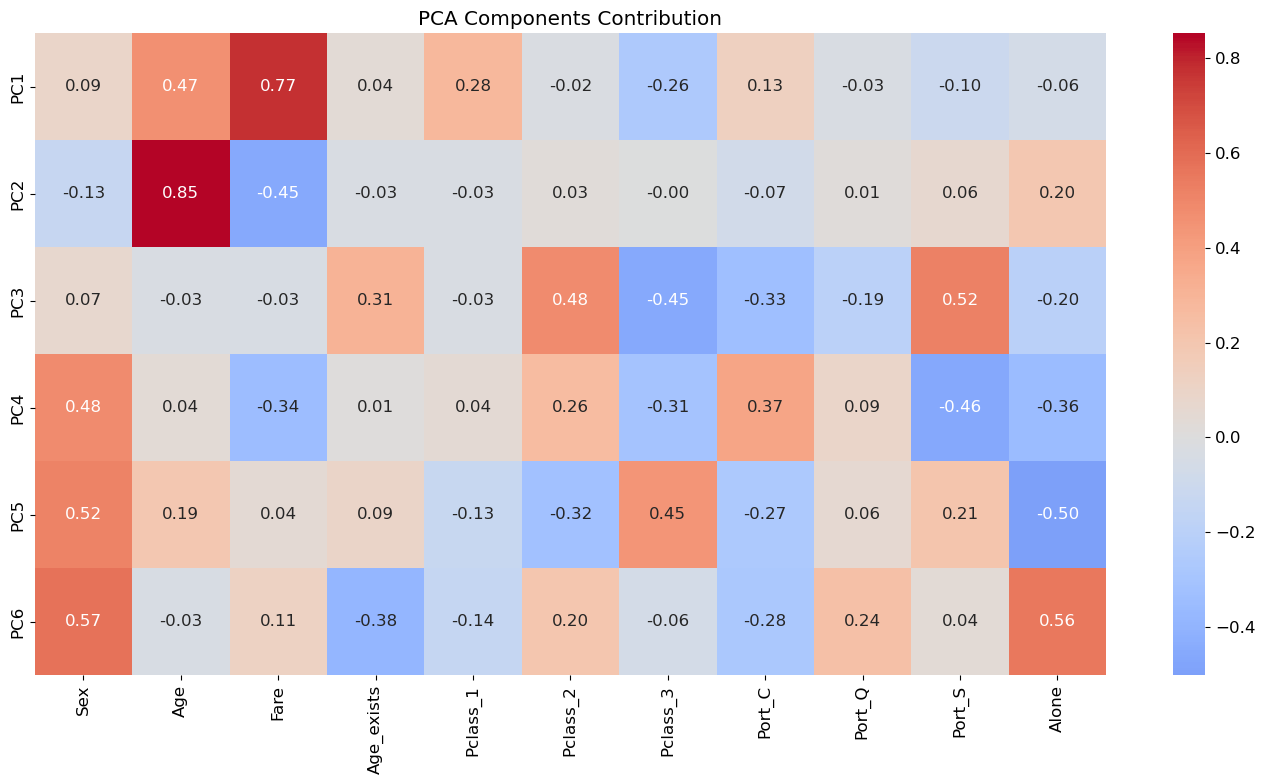

In [37]:
# Perform PCA
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(titanic_train.drop(columns='Survived'))
X_test_pca = pca.transform(titanic_test.drop(columns='Survived'))

# X_train = X_train_pca
# X_test = X_test_pca

# Print explained variance ratios
print("Explained variance ratios:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

print(f"\nTotal variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")
# 2. PCA Components Visualization
plt.figure(figsize=(14, 8))
components_df = pd.DataFrame(
    pca.components_,
    columns=['Sex', 'Age', 'Fare', 'Age_exists',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Port_C', 'Port_Q', 'Port_S', 'Alone'],
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
sns.heatmap(components_df, cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('PCA Components Contribution')
plt.tight_layout()
plt.show()

In [38]:
import os 
os.environ['KERAS_BACKEND'] = 'torch'

import numpy as np
import pandas as pd

import keras_tuner
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout, Input
from keras import losses, optimizers
from keras.api.utils import set_random_seed, to_categorical
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.api.regularizers import l2

set_random_seed(812)

def build_model(hp):
        hp_activation_layer_1 = hp.Choice('activation 1', values=['relu', 'tanh', 'squareplus', 'selu']) 
        hp_activation_layer_2 = hp.Choice('activation 2', values=['relu', 'tanh', 'squareplus', 'selu']) # , 'sparse_plus', 'silu'
        hp_activation_layer_3 = hp.Choice('activation 3', values=['relu', 'tanh', 'squareplus', 'selu'])
        hp_activation_layer_4 = hp.Choice('activation 3', values=['relu', 'tanh', 'squareplus', 'selu'])
        # hp_activation_layer_5 = hp.Choice('activation 3', values=['relu', 'tanh', 'sigmoid', 'squareplus', 'selu'])
        # hp_activation_layer_6 = hp.Choice('activation 3', values=['relu', 'tanh', 'sigmoid', 'squareplus', 'selu'])
        # hp_activation_layer_7 = hp.Choice('activation 3', values=['relu', 'tanh', 'sigmoid', 'squareplus', 'selu'])
        hp_layer_1 = hp.Int('units 1', min_value=4, max_value=4096, step=2, sampling='log')
        hp_layer_2 = hp.Int('units 2', min_value=4, max_value=4096, step=2, sampling='log')
        hp_layer_3 = hp.Int('units 3', min_value=4, max_value=4096, step=2, sampling='log')
        hp_layer_4 = hp.Int('units 3', min_value=4, max_value=4096, step=2, sampling='log')
        # hp_layer_5 = hp.Int('units 3', min_value=4, max_value=4096, step=2, sampling='log')
        # hp_layer_6 = hp.Int('units 3', min_value=4, max_value=4096, step=2, sampling='log')
        # hp_layer_7 = hp.Int('units 3', min_value=4, max_value=4096, step=2, sampling='log')
        # hp_dropout_rate_1 = hp.Float('rate 1', min_value=0.0, max_value=0.4, step=0.05)
        # hp_dropout_rate_2 = hp.Float('rate 2', min_value=0.0, max_value=0.4, step=0.05)
        # hp_dropout_rate_3 = hp.Float('rate 3', min_value=0.0, max_value=0.4, step=0.05)
        # hp_dropout_rate_4 = hp.Float('rate 3', min_value=0.0, max_value=0.4, step=0.05)
        # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # output_activation = threshold(0.5)

        model = Sequential()
        model.add(Input(shape=(X_train.shape[1],), name='Input_Layer'))
        model.add(Dense(hp_layer_1, activation=hp_activation_layer_1, kernel_regularizer=l2(0.01), name='hidden_1'))
        # model.add(Dropout(0.05, name='dropout_1_2'))
        model.add(Dense(hp_layer_2, activation=hp_activation_layer_2, kernel_regularizer=l2(0.01), name='hidden_2'))
        # model.add(Dropout(hp_dropout_rate_2, name='dropout_2_3'))
        model.add(Dense(hp_layer_3, activation=hp_activation_layer_3, kernel_regularizer=l2(0.01), name='hidden 3'))
        # model.add(Dropout(hp_dropout_rate_3))
        model.add(Dense(hp_layer_4, activation=hp_activation_layer_4, kernel_regularizer=l2(0.01), name='hidden_4'))
        # # model.add(Dropout(hp_dropout_rate_4, name='dropout_3_4'))
        # model.add(Dense(hp_layer_5, activation=hp_activation_layer_5, kernel_regularizer=l2(0.01), name='hidden_5'))
        # model.add(Dense(hp_layer_6, activation=hp_activation_layer_6, kernel_regularizer=l2(0.01), name='hidden_6'))
        # model.add(Dense(hp_layer_7, activation=hp_activation_layer_7, kernel_regularizer=l2(0.01), name='hidden_7'))

        model.add(Dense(1, activation='sigmoid', name='hidden_3_output'))

        # hp_alpha = hp.Float('units alpha', min_value=0.0, max_value=0.5, step=0.05)
        # hp_reduction = hp.Choice('reduction', ["sum", "sum_over_batch_size", "mean", "mean_with_sample_weight"])
        # loss = losses.CategoricalFocalCrossentropy(
        #     alpha=hp_alpha,
        #     gamma=2.0,
        #     from_logits=False,
        #     label_smoothing=0.0,
        #     axis=-1,
        #     reduction=hp_reduction, # supported values: "sum", "sum_over_batch_size", "mean", "mean_with_sample_weight"
        #     name="categorical_focal_crossentropy",
        #     dtype=None,
        # )

        loss = losses.BinaryCrossentropy()
        opt = optimizers.Adam(learning_rate=1e-2)

        # opt = optimizers.Nadam(
        #     learning_rate=0.001,
        #     beta_1=0.9,
        #     beta_2=0.99,
        #     epsilon=1e-06,
        #     weight_decay=None,
        #     clipnorm=None,
        #     clipvalue=None,
        #     global_clipnorm=None,
        #     use_ema=False,
        #     ema_momentum=0.99,
        #     ema_overwrite_frequency=None,
        #     loss_scale_factor=None,
        #     gradient_accumulation_steps=None,
        #     name="nadam"
        # )

        model.compile(loss=loss, optimizer=opt, metrics=['accuracy']) # f1-score doesn't work due to location of data - device issus (gpu / cpu)

        return model

<h1>Importing submission data</h1>

In [39]:
test_data = pd.read_csv("test_data.csv", index_col=0)
test_data['Age_exists'] = ~test_data.Age.isna()
pclass_dummies = pd.get_dummies(test_data.Pclass, prefix="Pclass")
test_data.drop(columns="Pclass", inplace=True)
test_data = pd.concat([test_data, pclass_dummies], axis=1)
embarked_dummies = pd.get_dummies(test_data.Embarked, prefix="Port")
test_data.drop(columns="Embarked", inplace=True)
test_data = pd.concat([test_data, embarked_dummies], axis=1)
test_data.replace({True:1, False:0}, inplace=True)
# Impute Age
test_data.Age = imp_age.transform(test_data.Age.values.reshape(-1,1))
# Scale numeric values
test_data.loc[:,["Age", "Fare"]] = standard_scaler.transform(test_data.loc[:,["Age", "Fare"]])
test_data

/var/folders/5h/2vw4rj5908l26t38hd8pzjyc0000gn/T/ipykernel_56049/3730324129.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data.replace({True:1, False:0}, inplace=True)


,PassengerId,Sex,Age,SibSp,Parch,Fare,Age_exists,Pclass_1,Pclass_2,Pclass_3,Port_C,Port_Q,Port_S
0,892,0,0.352773,0,0,-0.492347,1,0,0,1,0,1,0
1,893,1,1.318087,1,0,-0.509833,1,0,0,1,0,0,1
2,894,0,2.476463,0,0,-0.453161,1,0,1,0,0,1,0
3,895,0,-0.226415,0,0,-0.474776,1,0,0,1,0,0,1
4,896,1,-0.612540,1,1,-0.398335,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,0.000000,0,0,-0.487691,0,0,0,1,0,0,1
414,1306,1,0.700286,0,0,1.638943,1,1,0,0,1,0,0
415,1307,0,0.661674,0,0,-0.504561,1,0,0,1,0,0,1
416,1308,0,0.000000,0,0,-0.487691,0,0,0,1,0,0,1


In [ ]:
print(test_data.describe())
# Feature engineering on SibSp & Parch
relatives = test_data.loc[:, ['SibSp', 'Parch']]
num_relatives = relatives.sum(axis='columns')
test_data['Alone'] = num_relatives.apply(lambda x: 1 if x == 0 else 0)
test_data.drop(columns=['SibSp', 'Parch'], inplace=True)

X_submission = test_data.drop(columns="PassengerId").values
# X_submission = pca.transform(X_submission)
print(X_submission.shape)

\begin{tabular}{rrrrrrrrrrrrr}
\toprule
PassengerId & Sex & Age & SibSp & Parch & Fare & Age_exists & Pclass_1 & Pclass_2 & Pclass_3 & Port_C & Port_Q & Port_S \\
\midrule
418.00 & 418.00 & 418.00 & 418.00 & 418.00 & 418.00 & 418.00 & 418.00 & 418.00 & 418.00 & 418.00 & 418.00 & 418.00 \\
1100.50 & 0.36 & 0.02 & 0.45 & 0.39 & 0.09 & 0.79 & 0.26 & 0.22 & 0.52 & 0.24 & 0.11 & 0.65 \\
120.81 & 0.48 & 0.98 & 0.90 & 0.98 & 1.18 & 0.40 & 0.44 & 0.42 & 0.50 & 0.43 & 0.31 & 0.48 \\
892.00 & 0.00 & -2.30 & 0.00 & 0.00 & -0.66 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
996.25 & 0.00 & -0.54 & 0.00 & 0.00 & -0.49 & 1.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
1100.50 & 0.00 & 0.00 & 0.00 & 0.00 & -0.35 & 1.00 & 0.00 & 0.00 & 1.00 & 0.00 & 0.00 & 1.00 \\
1204.75 & 1.00 & 0.45 & 1.00 & 0.00 & 0.01 & 1.00 & 1.00 & 0.00 & 1.00 & 0.00 & 0.00 & 1.00 \\
1309.00 & 1.00 & 3.56 & 8.00 & 9.00 & 10.15 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 \\
\bottomrule
\end{tabular}

(418, 11)


In [17]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y)

callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, start_from_epoch=10) # monitor loss and stop if it doesn't change for three epochs
lr_decay = ReduceLROnPlateau(monitor='loss', patience=1, verbose=0, factor=0.5, min_lr=1e-7)
hp = keras_tuner.HyperParameters()
hp_batch_size = hp.Int('batch_size', min_value=2, max_value=128, step=2, sampling='log')

# tuner = keras_tuner.GridSearch(build_model, objective='val_accuracy',
#                                 directory='hyperparam', project_name='diabetes', overwrite=True)

tuner = keras_tuner.Hyperband(build_model,
                     objective=keras_tuner.Objective('val_accuracy', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='Hyperband',
                     project_name='titanic',
                     overwrite=True)


categorical_y_train = y_train
categorical_y_test = y_test

tuner.search(X_train, categorical_y_train, batch_size=64, epochs=100, validation_split=0.2, 
             callbacks=[callback, lr_decay], class_weight=class_weight)


best_model = tuner.get_best_models()[0]
print(best_model.summary())
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, categorical_y_train, epochs=50, validation_split=0.2, class_weight=class_weight) #validation_data=(X_val, y_val)), class_weight=class_weight

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, categorical_y_train, epochs=best_epoch,callbacks=[callback, lr_decay], validation_split=0.2, class_weight=class_weight) #validation_data=(X_val, y_val)), 
hypermodel.save('titanic_model.keras')
print("Evaluation Model")
hypermodel.evaluate(X_test, y_test)
print(tuner.get_best_hyperparameters)

Trial 131 Complete [00h 00m 11s]
val_accuracy: 0.611940324306488

Best val_accuracy So Far: 0.858208954334259
Total elapsed time: 00h 02m 37s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden 3 (Dense)                │ (None, 4)              │        16,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3_output (Dense)         │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,157 (4.09 MB)

 Trainable params: 1,072,157 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5276 - loss: 4.1647 - val_accuracy: 0.6418 - val_loss: 1.3297
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7356 - loss: 1.1706 - val_accuracy: 0.6493 - val_loss: 0.8969
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7355 - loss: 0.8795 - val_accuracy: 0.7910 - val_loss: 0.6604
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8228 - loss: 0.6469 - val_accuracy: 0.8060 - val_loss: 0.5677
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8013 - loss: 0.5785 - val_accuracy: 0.8134 - val_loss: 0.5324
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8090 - loss: 0.5632 - val_accuracy: 0.7687 - val_loss: 0.5512
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8055 - loss: 0.5462 - val_accuracy: 0.7985 - val_loss: 0.5498
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7959 - loss: 0.6080 - val_accuracy: 0.806

In [18]:
data = []
for trial in tuner.oracle.trials.values():
    row = trial.hyperparameters.values.copy()
    row['score'] = trial.score
    data.append(row)

df = pd.DataFrame(data)
# Sort by score (ascending or descending depending on objective)
df_sorted = df.sort_values(by="score", ascending=False) 
df_sorted.head(10)


,activation 1,activation 2,activation 3,units 1,units 2,units 3,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,score,tuner/trial_id
101,relu,relu,selu,256,4096,4,10,1,2,1,0.858209,0041
129,relu,tanh,selu,128,4096,64,100,0,0,0,0.843284,NaN
108,relu,tanh,relu,128,256,512,10,1,2,1,0.843284,0020
105,selu,tanh,selu,64,32,512,10,1,2,1,0.835821,0093
104,tanh,relu,relu,128,8,128,10,1,2,1,0.835821,0084
110,relu,relu,selu,256,4096,4,100,10,2,2,0.835821,0101
109,relu,relu,tanh,128,64,16,10,1,2,1,0.835821,0043
125,tanh,selu,selu,16,32,1024,10,0,1,0,0.835821,NaN
122,tanh,tanh,squareplus,64,128,16,10,0,1,0,0.835821,NaN
115,tanh,selu,selu,64,4,512,10,0,1,0,0.835821,NaN


<h1>Simple Perceptron</h1>

Epoch 1: Prediction 1; Label 0
Epoch 101: Prediction 1; Label 1
Epoch 201: Prediction 0; Label 0
Epoch 301: Prediction 1; Label 1
Epoch 401: Prediction 0; Label 1
Epoch 501: Prediction 0; Label 1
Epoch 601: Prediction 0; Label 0
Epoch 701: Prediction 0; Label 0
Epoch 801: Prediction 0; Label 1
Epoch 901: Prediction 0; Label 1
Final weights and bias: 0.07885359691576743 0.010617586826144193 0.1745732746012304 0.04642147629764551 0.9729424283280245 0.7533989748458224 1.0843591354096902 -0.02612233474116768 -0.2561563606294591 -0.4404055611238593 0.037275949607206676 bias = -0.79

223 223
Smiple Perceptron               precision    recall  f1-score   support

           0       0.67      0.77      0.72       137
           1       0.52      0.40      0.45        86

    accuracy                           0.63       223
   macro avg       0.60      0.58      0.58       223
weighted avg       0.61      0.63      0.62       223



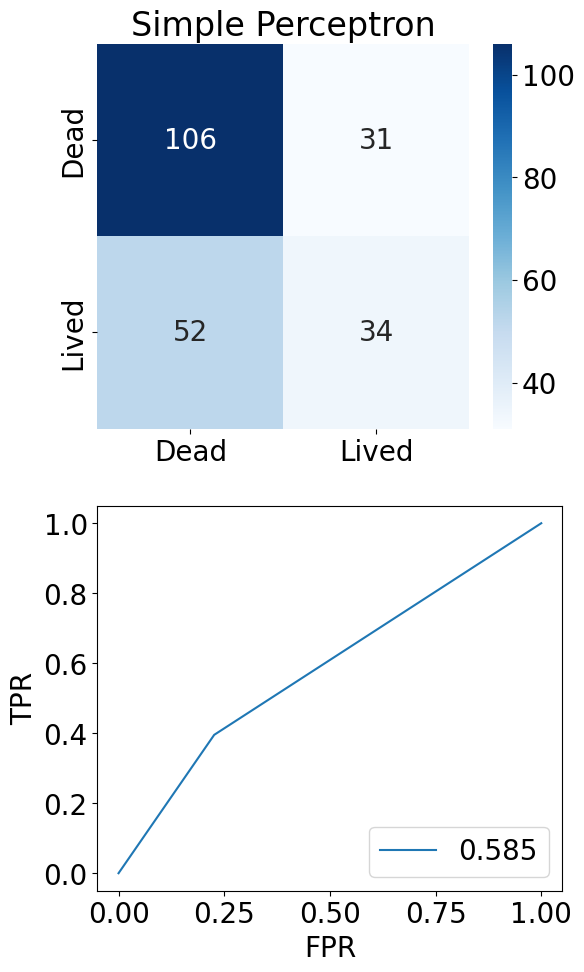

In [ ]:
import random
random.seed(42)
weights = [random.uniform(0,2), random.uniform(0,2), random.uniform(0,2), random.uniform(0,2), random.uniform(0,2), 
           random.uniform(0,2), random.uniform(0,2), random.uniform(0,2), random.uniform(0,2), random.uniform(0,2), 
           random.uniform(0,2)]
bias = random.uniform(0,2)
epochs = 1000
learning_rate = 0.1
def step_function(y_pred):
    if y_pred >= 0:
        return 1
    else:
        return 0
# Training the model
weighted = False
for epoch in range(epochs):
    x = X_train[random.randint(0, X_train.shape[0]-1)]
    y_true = y_train[random.randint(0, X_train.shape[0]-1)]
    y_pred = step_function(np.dot(x, weights) + bias)
    if (epoch) % 100 == 0:
        print(f'Epoch {epoch+1}: Prediction {y_pred}; Label {y_true}')
    for i in range(len(weights)):
        if weighted:
            if y_pred == 1:
                weights[i] = weights[i] + learning_rate * (y_true - y_pred) * x[i]
            else:
                weights[i] = weights[i] + learning_rate * (y_true - y_pred) * x[i]
        else:
            weights[i] = weights[i] + learning_rate * (y_true - y_pred) * x[i]
    if y_pred == 1 and weighted:
        bias = bias + learning_rate * (y_true - y_pred)
    elif y_pred == 0 and weighted:
        bias = bias + learning_rate * (y_true - y_pred)
    else:
        bias = bias + learning_rate * (y_true - y_pred)
    
print(f'Final weights and bias: {" ".join(str(i) for i in weights)} bias = {bias:.2f}\n')

y_pred = []
for X in X_test:
    y_pred.append(step_function(np.dot(X, weights)+bias))
print(len(y_test), len(y_pred))
# print(y_pred)

fig, ax = plt.subplots(2, 1, figsize=(6, 11)) 
ax[0].set_title("Simple Perceptron")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Dead", "Lived"],
            yticklabels=["Dead", "Lived"],
            ax=ax[0])
print("Smiple Perceptron", classification_report(y_test, y_pred))
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
# ax[1] = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score)
sns.lineplot(x=fpr, y=tpr, label=f"{auc_score:.3f}", ax=ax[1], legend='brief')
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].legend(loc='lower right')
plt.show()
y_pred = []
for X in X_submission:
    y_pred.append(step_function(np.dot(X, weights)+bias))
df_submission = pd.DataFrame(zip(test_data.PassengerId.copy(), y_pred), columns=["PassengerId", "Survived"])
df_submission.to_csv(f"test_prediction_Simple_Perceptron.csv", index=False)

RandomForestClassifier               precision    recall  f1-score   support

           0       0.80      0.88      0.84       137
           1       0.77      0.65      0.70        86

    accuracy                           0.79       223
   macro avg       0.78      0.76      0.77       223
weighted avg       0.79      0.79      0.79       223

GradientBoostingClassifier               precision    recall  f1-score   support

           0       0.82      0.91      0.86       137
           1       0.82      0.69      0.75        86

    accuracy                           0.82       223
   macro avg       0.82      0.80      0.80       223
weighted avg       0.82      0.82      0.82       223



/Users/christophhagenauer/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
320 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/christophhagenauer/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/christophhagenauer/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/christophhagenauer/anaconda3/envs/pytorch/lib/p

LogisticRegression               precision    recall  f1-score   support

           0       0.79      0.83      0.81       137
           1       0.71      0.65      0.68        86

    accuracy                           0.76       223
   macro avg       0.75      0.74      0.75       223
weighted avg       0.76      0.76      0.76       223

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sequential               precision    recall  f1-score   support

           0       0.80      0.87      0.84       137
           1       0.76      0.66      0.71        86

    accuracy                           0.79       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223



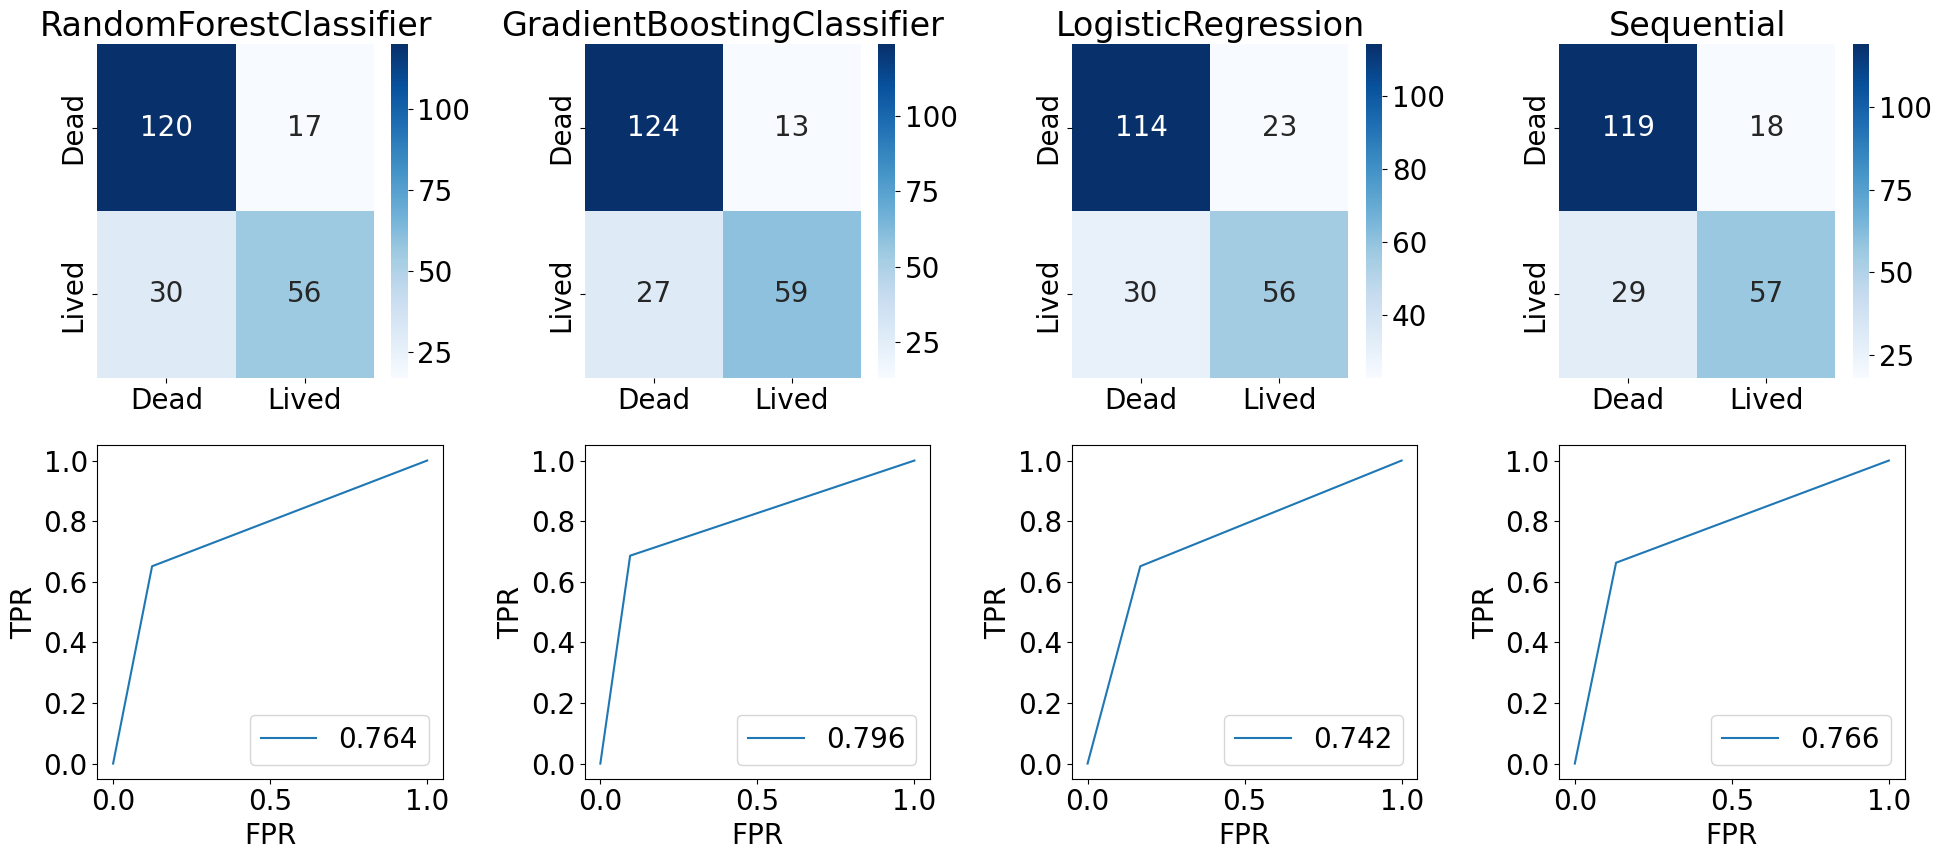

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
fig, ax = plt.subplots(2, 4, figsize=(20, 9))  # create 2 row, 4 columns of subplots

gbc = GradientBoostingClassifier()
lg = LogisticRegression(max_iter=10000, n_jobs=-1)
rf = RandomForestClassifier(n_jobs=-1)
classifiers = [rf, gbc, lg, hypermodel]
parameters_rf = { 'n_estimators':[100, 1000, 10000], 'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':[2,4,8,16],
                 'class_weight':(None, class_weight)}
parameters_lg = {'penalty':('l2', None), 'dual':(True, False), 'fit_intercept':(True, False), 
              'class_weight':(class_weight, None), 'solver':('lbfgs', 'newton-cg', 'sag', 'saga')}
parameters_gbc = {'loss':('log_loss', 'exponential'), 'learning_rate':[0.1, 0.001], 'n_estimators':[100, 10000], 
                  'criterion':('friedman_mse', 'squared_error'), 'max_features': ('sqrt', 'log2')}
parameters = [parameters_rf, parameters_gbc, parameters_lg]

perform_search =  True
for col, classifier in enumerate(classifiers):
    if classifier != hypermodel: 
        if perform_search:
            search = HalvingGridSearchCV(classifier, parameters[col], n_jobs=-1, cv=10)
            search.fit(X_train, y_train)
            y_pred = search.predict(X_test)
            y_submisson_predict = search.predict(X_submission)
        else:
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)       
    else:
        y_pred = classifier.predict(X_test)
        y_pred = (y_pred[:, 0] > 0.445).astype(int)
        y_submisson_predict = classifier.predict(X_submission)
        y_submisson_predict = (y_submisson_predict[:, 0] > 0.445).astype(int)
    # Save prediction for competition
    df_submission = pd.DataFrame(zip(test_data.PassengerId.copy(), y_submisson_predict), columns=["PassengerId", "Survived"])
    df_submission.to_csv(f"test_prediction_{str(classifier.__class__.__name__)}.csv", index=False)
    # Print metrics
    print(str(classifier.__class__.__name__), classification_report(y_test, y_pred))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Dead", "Lived"],
                yticklabels=["Dead", "Lived"], 
                ax=ax[0, col])
    ax[0, col].set_title(str(classifier.__class__.__name__))
    # ROC Curve and AUC score
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)
    sns.lineplot(x=fpr, y=tpr, label=f"{auc_score:.3f}", ax=ax[1, col], legend='brief')
    ax[1, col].set_xlabel("FPR")
    ax[1, col].set_ylabel("TPR")
    ax[1, col].legend(loc='lower right')
plt.tight_layout()
plt.show()
